In [110]:
%store -r SPE27_clean

In [111]:
%store -d SPE_clean
SPE_clean = SPE27_clean

In [113]:
from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import copy
from scipy.fft import fft, ifft, fftfreq

In [114]:
print(len(SPE_clean))

6760


In [115]:
plt.style.use("LateLightStyle.mplstyle")

In [86]:
# What happens if I try putting the responsive fitting thing to MCK?

# exp fitting
def exp_func(t, t_0, A, B):
    y = np.piecewise(t, [t <= t_0], [A*np.exp(-(t-t_0)**4/B)])
    return y

def exp_fit(waveform):
    pars, conv = optimize.curve_fit(f=exp_func, xdata=np.linspace(0,9,num=9), ydata=abs(waveform[0:9]))
    return pars, conv

In [87]:
# Rethink the fit, set bounds for parameters (The idea for bounds might be the way to go)

# exp fitting
def exp_func(t, t_0, A, B):
    return A*np.exp(-(t-t_0)**4/B)

def exp_fit(waveform_raw):
    waveform = list(waveform_raw[:np.where(waveform_raw==max(waveform_raw))[0][0]+1])
    pars, conv = optimize.curve_fit(f=exp_func, xdata=np.linspace(0,len(waveform),num=len(waveform)), ydata=waveform, 
                                    bounds=([waveform.index(max(waveform))-9.0,max(waveform)-0.5,"-inf"],[waveform.index(max(waveform))+9.0,max(waveform)+0.5,"inf"]))
    #pars, conv = optimize.curve_fit(f=exp_func, xdata=np.linspace(0,len(waveform),num=len(waveform)), ydata=waveform, 
                                    #bounds=(["-inf",max(waveform)-0.5,"-inf"],["inf",max(waveform)+0.5,"inf"]))
    return pars, conv

[12.1451532  18.5        53.09321313]


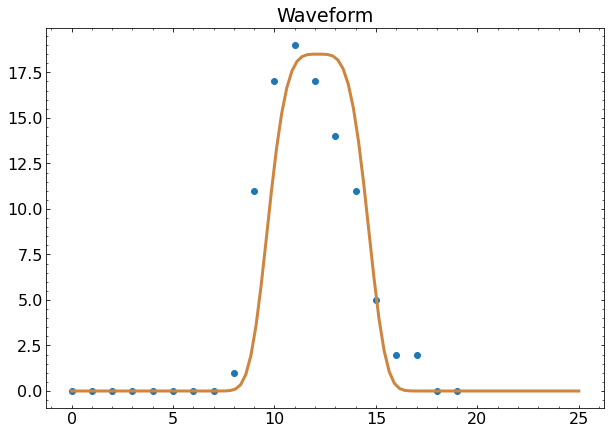

In [88]:

fit_out = exp_fit(SPE_clean[714])
test = fit_out[0]
print(test)


fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPE_clean[714][0:20], linestyle="none", marker="o")
ax.plot(np.linspace(0,25,num=100), [exp_func(i, test[0], test[1], test[2]) for i in np.linspace(0,25,num=100)], color="peru")
ax.set_title("Waveform")
plt.show()

# IMPORTANT: right now all the time parameters are still in ticks not ns
# Also, is matching the value of amplitudes of fit and data the best way to find best fit? 

In [8]:
# Try linearizing the fitting
# Functions for fitting all waveforms

'''
# exp fitting
def exp_func(t, t_0, A, B):
    return A-(t-t_0)**4/B

# a responsive exp fitting function that minimizes the distance between the fitted amplitude and amplitude from data
def exp_fit(waveform):
    pars, conv = optimize.curve_fit(f=exp_func, xdata=np.linspace(9,20,num=11), ydata=np.log(abs(waveform[9:20])))
    return pars,conv
'''

'\n# exp fitting\ndef exp_func(t, t_0, A, B):\n    return A-(t-t_0)**4/B\n\n# a responsive exp fitting function that minimizes the distance between the fitted amplitude and amplitude from data\ndef exp_fit(waveform):\n    pars, conv = optimize.curve_fit(f=exp_func, xdata=np.linspace(9,20,num=11), ydata=np.log(abs(waveform[9:20])))\n    return pars,conv\n'

[11.38354943 20.5        14.87530508]


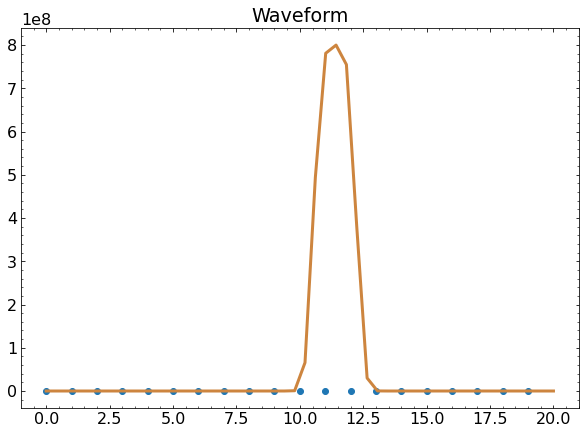

In [9]:
fit_out = exp_fit(SPE_clean[0])
test = fit_out[0]
print(test)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPE_clean[0][0:20], linestyle="none", marker="o")
ax.plot(np.linspace(0,20,num=50), [np.exp(exp_func(i, test[0], test[1], test[2])) for i in np.linspace(0,20,num=50)], color="peru")
ax.set_title("Waveform")
plt.show()

In [10]:
# fit to all SPE data
# reject the ones with not enough data on rising edge

SPE_data = np.array(["waveforms","fit parameters"])

for i in SPE_clean:
    SPE_temp = [i]
    try:
        SPE_temp.append(exp_fit(i)[0])
    except RuntimeError:
        SPE_temp.append("Rejected")
    SPE_data = np.vstack([SPE_data, SPE_temp])


F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-6-3fd303b23991>:5: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-(t-t_0)**4/B)


KeyboardInterrupt: 

In [ ]:
# Plotting out all the waveforms and their fits (raw fits)

k = 0

fig, ax = plt.subplots(figsize =(10, 7))
for j in SPE_data[1:]:
    if j[1] == "Rejected":
        k += 1
    else:
        ax.plot(j[0][0:30], linewidth=0.5, color="blue")
        ax.plot([i for i in np.linspace(0,30,num=50)], [exp_func(i,j[1][0],j[1][1],j[1][2]) for i in np.linspace(0,30,num=50)], color="peru", alpha=0.5)

ax.set_title("Waveform")
ax.set_ylabel("Amplitude (ADU)")
ax.set_xlabel("Time (ticks)")
plt.show()

print(k)
# Are these good enough? The rising edge doesn't seem to be captured perfectly

In [ ]:
# create an empty SPE kernel 2d array
# 300 bins from 0ns to 300ns, bin size 1ns

# timespan = 300

#exp_kernel_arr = np.empty(shape=(300,), dtype=object)
exp_kernel_arr = np.zeros(shape=(300,), dtype=object)
print(exp_kernel_arr[119])

In [ ]:
print(type(SPE_data[0][1][0])==str)

In [ ]:
# time correct and normalize the selected SPEs, then place them into their corresponding bins
# Doing all three steps in the same loop because all the varaibles are ready


for i in range(len(SPE_data)):
    # the normalization constant could be subject to change, check PMTViewer.py
    norm_cst = 1
    if type(SPE_data[i][1][0]) == str:
        pass
    else:
        for j in range(len(SPE_data[i][0])):
            n = int(round((j-SPE_data[i][1][0])*15.625))+100
            if 0<n<300:
                exp_kernel_arr[n-1] = np.append(exp_kernel_arr[n-1], SPE_data[i][0][j]/norm_cst)
            else:
                pass

# Quick formatting fix

exp_kernel_arr = exp_kernel_arr[1:-1]

In [ ]:
k=0

for i in exp_kernel_arr:
    try:
        print(len(i))
    except TypeError:
        print("none")
        k += 1
print(f"Out of 300 bins {k} are empty")

In [ ]:
exp_kernel_wf = [np.mean(i[1:]) for i in exp_kernel_arr]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(exp_kernel_arr)):
    ax.plot([i for j in range(len(exp_kernel_arr[i])-1)], exp_kernel_arr[i][1:], color="blue", linestyle="none", marker=".", markersize=1)
ax.set_title("Kernel and Waveform")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Amplitude")
ax.plot(exp_kernel_wf, color="red")
plt.show()

In [ ]:
#exp_kernel_wf = [np.mean(i[1:]) for i in exp_kernel_arr]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(exp_kernel_arr)):
    # Temporary if statement to ignore the none stuff
    if type(exp_kernel_arr[i]) != int:
        ax.plot([i for j in range(len(exp_kernel_arr[i])-1)], exp_kernel_arr[i][1:], color="blue", linestyle="none", marker=".", markersize=1)
        ax.plot(i, np.mean(exp_kernel_arr[i][1:]), color="red", linestyle="none", marker=".")
    else:
        ax.plot(i, 0, color="blue", linestyle="none", marker=".", markersize=1)
    ax.plot([i*15.625 for i in range(20)], [0 for i in range(20)], color="peru", linestyle="none", marker=".")
    ax.set_title("Kernel and Waveform")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
#ax.plot(exp_kernel_wf, color="red")
plt.show()

In [ ]:
# Plot the fit functions using ticks and see if it smears similar to the kernel

k = 0

fig, ax = plt.subplots(figsize =(10, 7))
for j in SPE_data[1:]:
    if j[1] == "Rejected":
        k += 1
    else:
        ax.plot([(i-j[1][0])*15.625 for i in range(20)], j[0][5:25], linestyle="none", marker=".", markersize=1, color="blue")
        #ax.plot([i for i in np.linspace(0,30,num=50)], [exp_func(i,j[1][0],j[1][1],j[1][2]) for i in np.linspace(0,30,num=50)], color="peru", alpha=0.5)

ax.set_title("Waveform")
ax.set_ylabel("Amplitude (ADU)")
ax.set_xlabel("Time (ticks)")
plt.show()

In [ ]:
foo = []
foo.append([["bar", "ye"]])
foo.append([["b", "e"]])
print(foo[0])

In [ ]:
# Try the same kernel procedures with less resolution

# create an empty SPE kernel 2d array
# 100 bins from 0ns to 300ns, bin size 3ns

# timespan = 300

expkarr_low = np.zeros(shape=(30,), dtype=object)
print(expkarr_low[2])

In [ ]:
# time correct and normalize the selected SPEs, then place them into their corresponding bins
# Doing all three steps in the same loop because all the varaibles are ready


for i in range(len(SPE_data)):
    # the normalization constant could be subject to change, check PMTViewer.py
    norm_cst = 1
    if type(SPE_data[i][1][0]) == str:
        pass
    else:
        for j in range(len(SPE_data[i][0])):
            n = int(round((round((j-SPE_data[i][1][0])*15.625)+100)/10))
            if 0<n<30:
                expkarr_low[n-1] = np.append(expkarr_low[n-1], SPE_data[i][0][j]/norm_cst)
            else:
                pass

# Quick formatting fix

expkarr_low = expkarr_low[1:-1]

In [ ]:
expkarr_low_wf = [np.mean(i[1:]) for i in expkarr_low]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(expkarr_low)):
    ax.plot([i for j in range(len(expkarr_low[i])-1)], expkarr_low[i][1:], color="blue", linestyle="none", marker=".", markersize=1)
ax.set_title("Kernel and Waveform")
ax.set_xlabel("Time bins (10 ns)")
ax.set_ylabel("Amplitude")
ax.plot(expkarr_low_wf, color="red")
plt.show()

## Developing Kernels with 15.625ns resolution

In [116]:
# Simply time align all peaks and take average of the kernel

# Time span of kernel: 200 ticks (200*15.625ns = 3125ns)
# Still continue to work with ticks

expkarr_og = np.zeros(shape=(200,), dtype=object)

for i in range(len(SPE_clean)):
    # the normalization constant could be subject to change, check PMTViewer.py
    norm_cst = 1
    # Enter the peak aligned waveforms into the kernel
    # If there are two maximum values, take the earlier one
    n = np.where(SPE_clean[i] == max(SPE_clean[i]))[0][0]
    for j in range(len(expkarr_og)):
        expkarr_og[j] = np.append(expkarr_og[j], SPE_clean[i][n-8+j]/norm_cst)

In [1]:
# Plot the kernel and its fit

expkarr_og_wf = [np.mean(i[1:]) for i in expkarr_og]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(expkarr_og)):
    ax.plot([i for j in range(len(expkarr_og[i])-1)], expkarr_og[i][1:], color="cornflowerblue", linestyle="none", marker=".", markersize=1, alpha=0.7)
ax.set_title("Kernel and Waveform")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
ax.plot(expkarr_og_wf, color="red")
#ax.set_ylim(-5,5)
#ax.set_xlim(10,30)
plt.show()

NameError: name 'expkarr_og' is not defined

In [118]:
# Build kernel without any alignment

# Time span of kernel: 200 ticks (200*15.625ns = 3125ns)
# Still continue to work with ticks

# TODO: so far these different kernels all have slightly different prepulse and afterpulse times, 
# this need to be nailed down later

expkarr_raw = np.zeros(shape=(200,), dtype=object)

# the normalization constant could be subject to change, check PMTViewer.py
norm_cst = 1

for i in range(len(SPE_clean)):
    # Enter the peak aligned waveforms into the kernel
    for j in range(len(expkarr_raw)):
        expkarr_raw[j] = np.append(expkarr_raw[j], SPE_clean[i][j]/norm_cst)

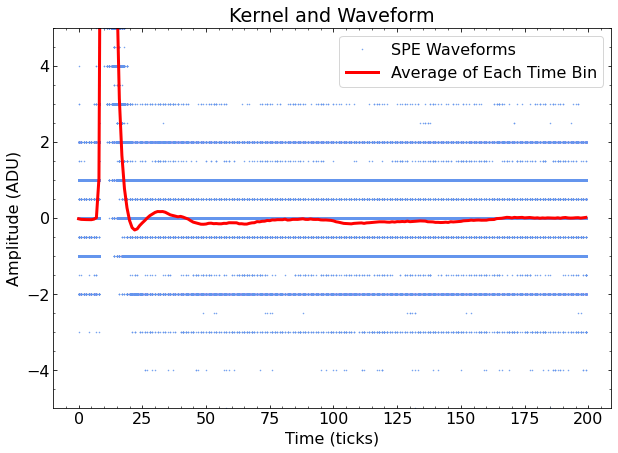

In [119]:
# Plot the kernel and its fit

expkarr_raw_wf = [np.mean(i[1:]) for i in expkarr_raw]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(expkarr_raw)):
    ax.plot([i for j in range(len(expkarr_raw[i])-1)], expkarr_raw[i][1:], color="cornflowerblue", linestyle="none", marker=".", markersize=1)
# Plot an extra waveform for generating a label
ax.plot([i for j in range(len(expkarr_raw[i])-1)], expkarr_raw[i][1:], color="cornflowerblue", linestyle="none", marker=".", markersize=1, label="SPE Waveforms")
ax.set_title("Kernel and Waveform")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
ax.plot(expkarr_raw_wf, color="red", label="Average of Each Time Bin")
ax.set_ylim(-5,5)
#ax.set_xlim(10,30)
plt.legend()
plt.show()

In [120]:
# Export the kernels

kaligned = expkarr_og_wf
kraw = expkarr_raw

%store kaligned
%store kraw

Stored 'kaligned' (list)
Stored 'kraw' (ndarray)


### Wiener filter SNR study

Develop Wiener filter SNR as a function of frequency, which will later be used for deconvolution

200


F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


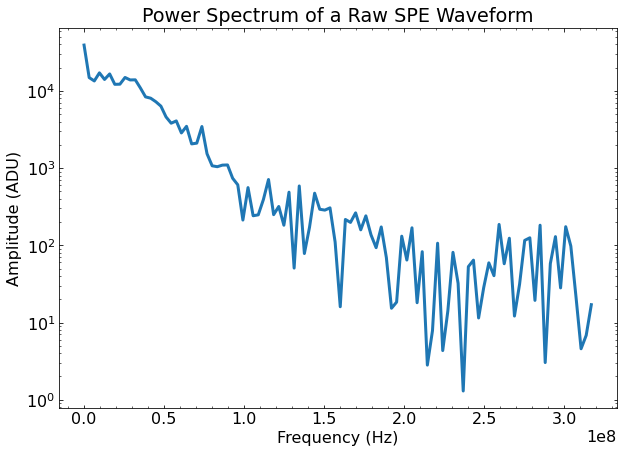

In [121]:
# Fourier transform individual SPEs
# rethink units

# TODO: This is not the correct power spectrum, redo this with the function fftfreq

SPE_ft = fft([expkarr_og[i][5] for i in range(len(expkarr_og))])
#SPE_ft = [expkarr_og[i][1] for i in range(len(expkarr_og))]

# Generate the power spectrum
n = SPE_ft.size
print(n)
SPEfreq = fftfreq(n, d=15.625)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPEfreq[:n//2]*10e9, (SPE_ft*np.conj(SPE_ft))[:n//2])
ax.set_title("Power Spectrum of a Raw SPE Waveform")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (ADU)")
ax.set_yscale("log")
#ax.set_ylim(-2,2)
#ax.set_xlim(10,30)
plt.show()

200


F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


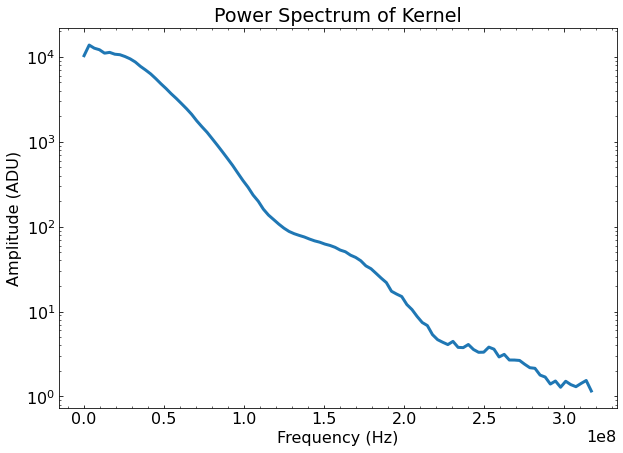

In [122]:
# Fourier transform the kernel

kernel_ft = fft(kaligned)

# Generate the power spectrum
#Only diplaying the positive frequencies

n = kernel_ft.size
print(n)
kfreq = fftfreq(n, d=15.625)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(kfreq[:n//2]*10e9, (kernel_ft*np.conj(kernel_ft))[:n//2])
ax.set_title("Power Spectrum of Kernel")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (ADU)")
ax.set_yscale("log")
#ax.set_ylim(-2,2)
#ax.set_xlim(10,30)
plt.show()

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


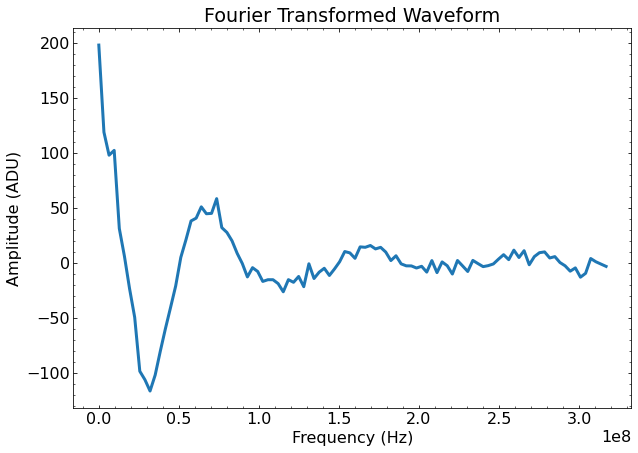

In [123]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(kfreq[:n//2]*10e9, SPE_ft[:n//2])
ax.set_title("Fourier Transformed Waveform")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(-2,2)
#ax.set_xlim(10,30)
plt.show()

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


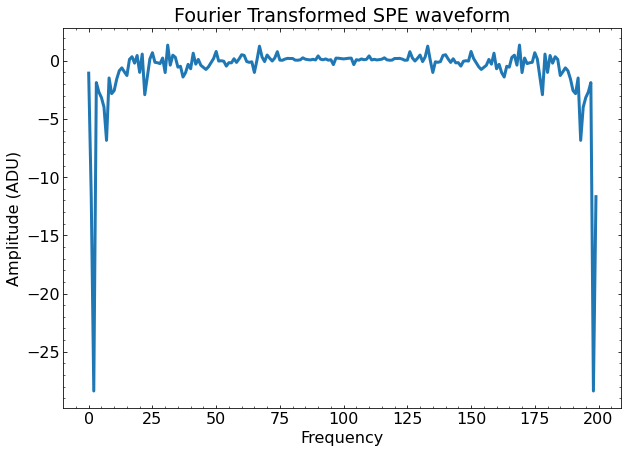

In [124]:
# The component that need to be subtracted
# TODO: Change plot labels

delta = kernel_ft - SPE_ft
snr_trial = kernel_ft/delta

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(snr_trial)
ax.set_title("Fourier Transformed SPE waveform")
ax.set_xlabel("Frequency")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(-2,2)
#ax.set_xlim(10,30)
plt.show()

In [125]:
# Load the average muon signal and the muon array

%store -r muon_tavg muon_arr

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


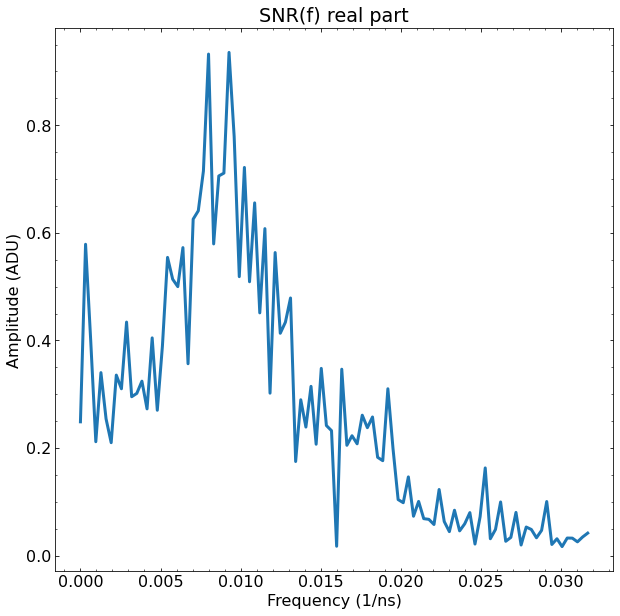

In [126]:
# Check out the frequency function if I compiled the Delta component of all waveforms
# Important: It is very clear that the large peaks are due to some outlier


def fnoise(waveform, kernel):
    fwf = fft(waveform)
    fkn = fft(kernel)
    return (fkn*np.conj(fkn))/(fwf*np.conj(fwf)-fkn*np.conj(fkn))

# Compile a noise response function in frequency space
noisearr = []
noiseres = np.zeros(len(expkarr_og), dtype="complex")

for i in range(len(expkarr_og[0])-1):
    noise_cache = fnoise([expkarr_og[j][i+1] for j in range(len(expkarr_og))], kaligned)
    if max(noise_cache) <= 1000 and min(noise_cache) >= -20:
        #print(i+1)
        noisearr.append(noise_cache)
        noiseres += noise_cache

snrf = noiseres/(len(expkarr_og[0])-1)

fig, ax = plt.subplots(figsize =(10, 10))
ax.plot(kfreq[:n//2], snrf[:n//2])
ax.set_title("SNR(f) real part")
ax.set_xlabel("Frequency (1/ns)")
ax.set_ylabel("Amplitude (ADU)")
#plt.yscale("log")
#ax.set_ylim(-10,10)
#ax.set_xlim(-10,10)
plt.show()

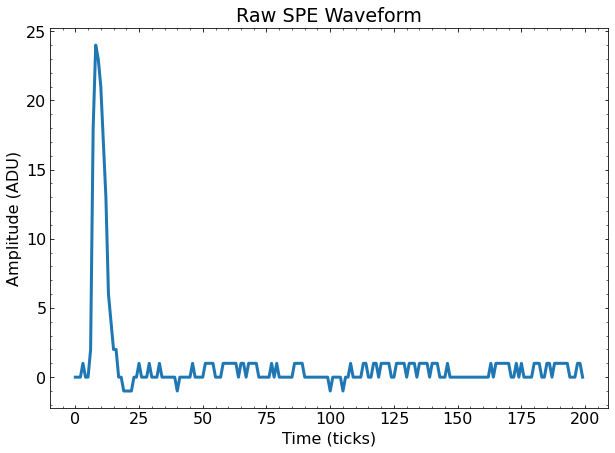

In [127]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot([expkarr_og[j][5] for j in range(len(expkarr_og))])
ax.set_title("Raw SPE Waveform")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(-10,10)
#ax.set_xlim(-10,10)
plt.show()

In [128]:
#mft = fft(muon_tavg)
mft = fft(expkarr_raw_wf)

In [129]:
# Take the average of the power spectrums of kernel+noise

specsum = np.zeros(len(expkarr_og), dtype="complex")


for i in range(len(expkarr_og[0])-1):
    fft_cache = fft([expkarr_og[j][i] for j in range(len(expkarr_og))])
    specsum += fft_cache*np.conj(fft_cache)
    #specsum += (fft_cache-mft)*np.conj(fft_cache-mft)

'''
for i in range(len(muon_arr[0][0][:200])):
    fft_cache = fft(muon_arr[i][0][:200])
    #specsum += fft_cache*np.conj(fft_cache)
    specsum += (fft_cache-mft)*np.conj(fft_cache-mft)
'''

specavg = specsum/(len(expkarr_og[0])-1)

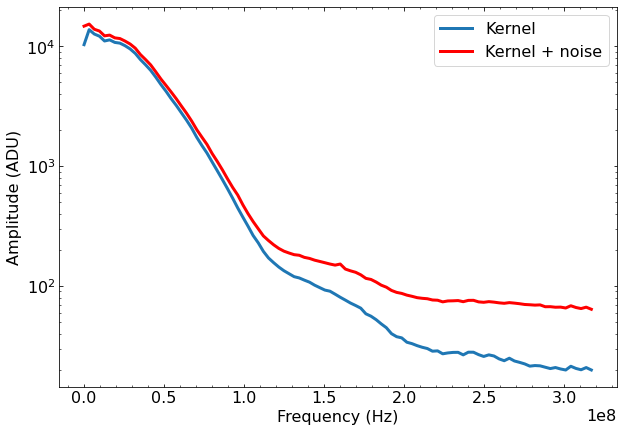

In [130]:


fig, ax = plt.subplots(figsize =(10, 7))
#for i in range(len(expkarr_og[0])-1):
    #ax.plot(kfreq[:n//2]*10e9, np.abs(fft([expkarr_og[j][i] for j in range(len(expkarr_og))]))[:n//2], color="peru", linewidth=0.5)
ax.plot(kfreq[:n//2]*10e9, np.abs(mft[0:n//2])**2, label="Kernel")
ax.plot(kfreq[:n//2]*10e9, np.abs(specavg[0:n//2]), color="red", label="Kernel + noise")
#ax.set_title("Power Spectrum for Kernel and SPE waveforms")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (ADU)")
ax.set_yscale("log")
plt.legend()
#ax.set_ylim(-10,10)
#ax.set_xlim(-10,10)
plt.show()

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


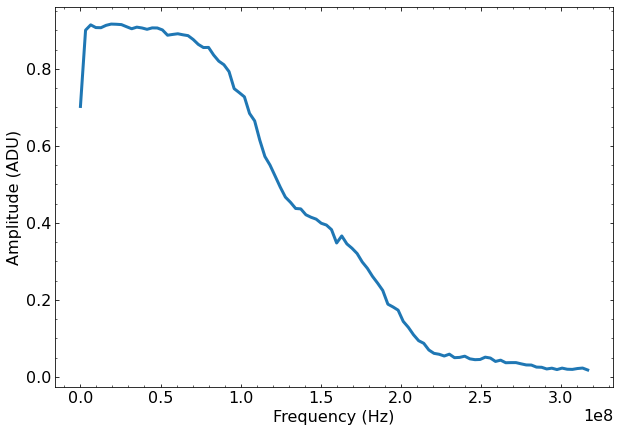

In [131]:
# Should it be wf**2-k**2 or (wf-k)**2?

#specnoise = (kernel_ft*np.conj(kernel_ft))/(specavg - (kernel_ft*np.conj(kernel_ft)))
specnoise = (kernel_ft*np.conj(kernel_ft))/(specavg)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(kfreq[:n//2]*10e9, specnoise[0:n//2])
#ax.set_title("Power Spectrum for each separate waveforms")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_yscale("log")
#ax.set_ylim(-100,100)
#ax.set_xlim(-100,100)
plt.show()

In [132]:
snrf = specnoise

%store snrf kfreq

Stored 'snrf' (ndarray)
Stored 'kfreq' (ndarray)


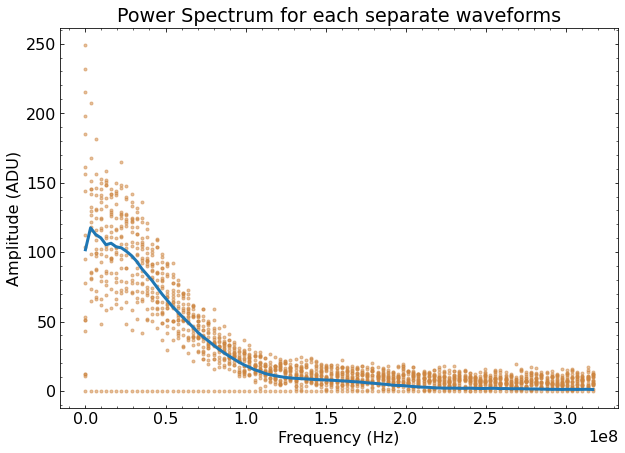

In [133]:
# Show the noise estimation for each waveform

fft([expkarr_og[i][5] for i in range(len(expkarr_og))])

fig, ax = plt.subplots(figsize =(10, 7))
#for i in range(len(expkarr_og[0])-1):
for i in range(20):
    ax.plot(kfreq[:n//2]*10e9, np.abs(fft([expkarr_og[j][i] for j in range(len(expkarr_og))]))[:n//2], color="peru", linewidth=0.5, linestyle="none", marker=".", alpha=0.5)
ax.plot(kfreq[:n//2]*10e9, np.abs(kernel_ft[0:n//2]))
ax.set_title("Power Spectrum for each separate waveforms")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(-10,40)
#ax.set_xlim(1.5e8,3.5e8)
plt.show()

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


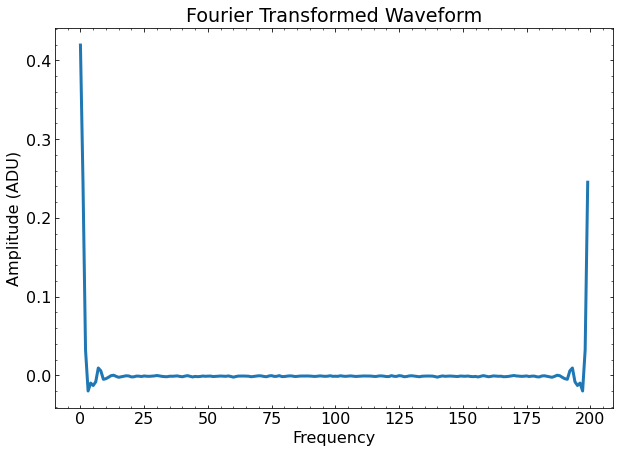

In [134]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(ifft(snrf))
ax.set_title("Fourier Transformed Waveform")
ax.set_xlabel("Frequency")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(-2,2)
#ax.set_xlim(10,30)
plt.show()

In [135]:
%store snrf

Stored 'snrf' (ndarray)
